# Clickbait EDA

In this competition we have a classification problem with **two classes**.  We are given a dataset containing, *time, article title, article captions, article text post, and snippets from the paragraphs of article* to determine if an article is clickbait or not-clickbait.

The dataset is presented as a json lines file which can be read into python with a loop and the python json library and then examined using pandas.  

This notebook looks at:

+ Basic word stats from the dataset
+ Determine clusters of words (topic-modeling)
+ Pairwise distances of words and the corresponding labels
+ Model selection, logistic regression and so on.






In [1]:
from gensim import corpora, models, similarities
import gensim
import json
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
import re
import int2word as iw
from nltk.tag import pos_tag
from nltk.corpus import words
from collections import defaultdict
import matplotlib.pyplot as plt
import os
from nltk.stem import WordNetLemmatizer
from sklearn.manifold import TSNE
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

c:\python27\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


**I separated the file into functions for now.**

In [2]:
# Function to convert a raw title to a string of words
# The input is a single string and the output is a single string of processed titles
def title_to_words( raw_title ):

    tknzer = TweetTokenizer()
    return tknzer.tokenize(raw_title)

def is_Number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

#tokenize paragraphs, for now I'm considering all the individual sentances as one big line 
def paragraph_to_words(raw_para):
    para = ' '.join(raw_para)
    #para = para.encode('utf-8').strip()
    tpara = word_tokenize(para)
    
    return tpara

#This function takes in the dataframes and analyzes the clickbait or not clickbait titles,
#you also have the option of analyzing the individual tokens, which make take a while, so
#the variable NoAna is either 0 or 1, 1 being for calculate individual tokens

def analyzeTitles(pandadata,pandaLdata, noAna):
    #tokenized titles
    ptitles = []
    
    #processed titles without stop words, numbers, and items that only appear once
    pStitles = []
    
    #All tokens
    aTokens = set()
    
    #Bait Tokens
    bTokens = set()
    
    stops = stopwords.words("english")       
    pattern = re.compile('([^\s\w]|_)+', re.UNICODE)
    porter = WordNetLemmatizer()
    
    for i in range(0,len(pandadata)):
        title = (title_to_words(pandadata['targetTitle'][i]))
        ptitles.append(title)
        title2 = ' '.join(title)
        title2 = title2.lower()
        title2 = pattern.sub('',title2)
        title2 = title2.split()
        title2 = [word for word in title2 if word not in stops]
        title2 = [porter.lemmatize(t) for t in title2]
        pStitles.append(list(title2))
        for ttoken in title:
            aTokens.add(ttoken)
            if pandaLdata['truthClass'][i] == "clickbait":
                bTokens.add(ttoken)
    
    #Removes infrequent tokens (usually names or proper nouns)
    frequency = defaultdict(int)
    
    for text in pStitles:
        for ttoken in text:
            frequency[ttoken] += 1
            
    pStitles = [[token for token in text if frequency[token] > 1] for text in pStitles]
    
    if noAna:
        #---------------for debuging
        #listofTokens = list(aTokens)
        #thefile = open('tokens.txt', 'w+')
        #for item in listofTokens:
        #    thefile.write("%s\n" % item.encode('utf-8'))
            
        #---------------Get token-data, number of stop words, english words, numbers, proper nouns, and words in all CAPS
            
        #Number of stop words
        sWords = []
        
        #Number of English words
        eWords = []
        
        #Number of "numbers"
        nNums = []
        
        #Number of Proper Nouns
        properWords = []
        
        #Number of ALL CAPS
        cNum = []
        
            
        #-----
        #This gets the tokens from the titles
        #------
        for i,token in enumerate(aTokens):
            (tagged,pos) = pos_tag([token])[0]
            if pos == 'NNP':
                properWords.append(token)
            if token in stops:
                sWords.append(token)
            if token in words.words():
                eWords.append(token)
            if is_Number(token):
                nNums.append(token)
            if token.isupper():
                cNum.append(token)
            
        return sWords, eWords, nNums, properWords, cNum, pStitles, ptitles, aTokens, bTokens
    else:
        return pStitles,ptitles

#Same process as analyzing the titles, we do the same thing with the paragraphs
def analyzePara(pandadata,pandaLdata,noAna):

    #tokenized titles
    pParagraphs = []
    
    #processed titles without stop words, numbers, and items that only appear once
    pSParagraphs = []
    
    #All tokens
    aTokens = set()
    
    #Bait Tokens
    bTokens = set()
    
    stops = stopwords.words("english")      
    pattern = re.compile('([^\s\w]|_)+', re.UNICODE)
    porter = WordNetLemmatizer()
    
    #Each paragraph is a set of lines, mainly the first line of each paragraph in the article
    for i in range(0,len(pandadata)):
   
        #not all articles have paragraphs
        thepara = pandadata['targetParagraphs'][i]
        if thepara:
            #for now I'm treating the individual lines as one
            paragraph = paragraph_to_words(thepara) 
            pParagraphs.append(paragraph)
            paragraph2 = ' '.join(paragraph)
            paragraph2 = paragraph2.lower()
            paragraph2 = pattern.sub('',paragraph2)
            paragraph2 = paragraph2.split()
            paragraph2 = [word for word in paragraph2 if word not in stops]
            paragraph2 = [porter.lemmatize(t) for t in paragraph2]
            pSParagraphs.append(paragraph2)
            for ttoken in paragraph:
                aTokens.add(ttoken)
                if pandaLdata['truthClass'][i] == "clickbait":
                    bTokens.add(ttoken)
    
    #Removes infrequent tokens (usually names or proper nouns)
    #frequency = defaultdict(int)
    
    #for text in pSParagraphs:
     #   for ttoken in text:
    #       frequency[ttoken] += 1
            
    #pSParagraphs = [[token for token in text if frequency[token] > 1] for text in pSParagraphs]
   
    if noAna: 
        #---------------Get token-data, number of stop words, english words, numbers, proper nouns, and words in all CAPS
            
        #Number of stop words
        sPWords = set()
        
        #Number of English words
        ePWords = set()
        
        
        #Number of "numbers"
        nPNums = []
        
        #Number of Proper Nouns
        properPWords = []
        
        #Number of ALL CAPS
        cPNum = []
        
        allthewords = set(words.words())    
        #-----
        #This gets the tokens from the titles
        #Inefficient way of doing it, probably better to do intersection of sets
        #------
        
        for i,token in enumerate(aTokens):
            (tagged,pos) = pos_tag([token])[0]
            if pos == 'NNP':
                properPWords.append(token)
            if is_Number(token):
                nPNums.append(token)
            if token.isupper():
                cPNum.append(token)
                
        sPWords = aTokens - stops
        ePWords = aTokens - allthewords
        
        return sPWords, ePWords, nPNums, properPWords, cPNum, pSParagraphs, pParagraphs, aTokens, bTokens
    else:
        return pSParagraphs

def getTime(theTime):
    #"<weekday> <month> <day> <hour>:<minute>:<second> <time_offset> <year>",
    utime = [int((x.split()[3])[0:2]) for x in theTime]
    return utime
    
    

In [3]:
##Now lets get the data

#Get current working directory, so anyone can use the notebook
path = os.getcwd()
pathI = path + "\\clickbait17-train-170331\\clickbait17-train-170331\\instances.jsonl" #Features
pathL = path + "\\clickbait17-train-170331\\clickbait17-train-170331\\truth.jsonl" #Labels
data = []

#file = open('C:\\Users\\rmeht\\Dropbox\\Algorithms\\Clickbait\\clickbait17-train-170331\\clickbait17-train-170331\\instances.json')
file = open(pathI)

for line in file:
    data.append(json.loads(line))

pandadata = pd.DataFrame(data)

file.close()

#file = open('C:\\Users\\rmeht\\Dropbox\\Algorithms\\Clickbait\\clickbait17-train-170331\\clickbait17-train-170331\\truth.jsonl')
file = open(pathL)

data = []

for line in file:
    data.append(json.loads(line))

pandaLdata = pd.DataFrame(data)

file.close()



In [4]:
print pandaLdata['truthClass'][5]

clickbait


#Text Data

Now that the data is in dataframes we can calculate word statistics and plot the various stats.  Here are the ones I'm calculating for now:

+ All English words
+ All Proper nouns 
+ All words with everything capitalized
+ All the numbers
+ All the stop words

Also since getting these words can be inefficient every run, I've decided to write them to a file.

In [4]:
####################Get properties of titles
#sWords, eWords, nNums, properWords, cNum, pStitles, ptitles, aTokens, bTokens = analyzeTitles(pandadata,pandaLdata)

##Write tokens to files using pickle, I initially used text files, but pickle is more efficient

#cpickle.dump(sWords,open("stopwords.p","wb"))
#cpickle.dump(eWords,open("engwords.p","wb"))
#cpickle.dump(nNums,open("Nums.p","wb"))
#cpickle.dump(properWords,open("properwords.p","wb"))
#cpickle.dump(cNums,open("capitalwords.p","wb"))
#cpickle.dump(aTokens,open("tokens.p","wb"))
#cpickle.dump(bTokens,open("baittokens.p","wb"))


#if already has tokens read in from files, (curently they are stored as text files)

pathW = path + '\\stopWords.txt'

sWords = [line.rstrip('\n') for line in open(pathW)]

pathW = path + '\\englishwords.txt'

eWords = [line.rstrip('\n') for line in open(pathW)]

pathW = path + '\\capitals.txt'

cWords = [line.rstrip('\n') for line in open(pathW)]

pathW = path + '\\numbers.txt'

nNums = [line.rstrip('\n') for line in open(pathW)]

pathW = path + '\\englishwords.txt'

eWords = [line.rstrip('\n') for line in open(pathW)]

pathW = path + '\\tokens.txt'

aTokens = [line.rstrip('\n') for line in open(pathW)]


#Once the files are placed using pickle, use this to open them:
#sWords = cpickle.load(open('stopwords.p','rb')) #pickle does not stake string obejcts

pStitles, ptitles = analyzeTitles(pandadata,pandaLdata,0)

 



In [42]:
#Are there specific topics/themes (clustering) in the vocabulary of click-bait titles, use LDA to find out
#Create a vocabulary from the titles

dTitles = corpora.Dictionary(pStitles)
cTitles = [dTitles.doc2bow(text) for text in pStitles] #the corpus

In [43]:
#Since words are usually very sparse, the TfidfModel transformation will take into account how common a word is in
#a certain document compared to how common it is overall 
#so the algorithm won't just be looking at the most common, but uninformative words like the or and.
dmap = lambda dct, a: [dct[e] for e in a]

tfidf = models.TfidfModel(cTitles)
tcorpus = dmap(tfidf, cTitles)

print "Calculating lda model for 5 topics"
lda5 = gensim.models.ldamodel.LdaModel(corpus=tcorpus, id2word=dTitles, num_topics=5, update_every=1, chunksize=10000, passes=10)

print "\n Calculating lda model for 10 topics"
lda10 = gensim.models.ldamodel.LdaModel(corpus=tcorpus, id2word=dTitles, num_topics=10, update_every=1, chunksize=10000, passes=10)

print "\n Calculating lda model for 15 topics"
lda15 = gensim.models.ldamodel.LdaModel(corpus=tcorpus, id2word=dTitles, num_topics=15, update_every=1, chunksize=10000, passes=10)

#print "\n Calculating lda model for 20 topics"
#lda20 = gensim.models.ldamodel.LdaModel(corpus=tcorpus, id2word=dTitles, num_topics=25, update_every=1, chunksize=10000, passes=10)


print "Finished LDA model for Clickbait Titles"


Calculating lda model for 5 topics

 Calculating lda model for 10 topics

 Calculating lda model for 15 topics
Finished LDA model for Clickbait Titles


In [26]:
#Save the models
#lda5.save('lda5.p')
#lda10.save('lda10.p')
#lda15.save('lda15.p')
#lda20.save('lda20.p')

#Load the models  -- looks like it doesn't work to well :(
#lda5 = gensim.models.ldamodel.LdaModel.load('lda5.p', mmap='r')
#lda10 =  gensim.models.ldamodel.LdaModel.load('lda10.p', mmap='r')
#lda15 =  gensim.models.ldamodel.LdaModel.load('lda15.p', mmap='r')

In [44]:
_kwargs = dict(formatted=0, num_words=20)

#**dict means "treat the key-value pairs in the dictionary as additional named arguments to this function call."
#topic words stores the word probablity for top 20 words in each topic. so it is a list of probablity of word in topic P(W|Z=z)
topic_words = [[words for words in tups[1]] for tups in lda5.show_topics(**_kwargs)]

#topicPdoc is an iterator that is transformed to contain the probablity of each topic in a document so, P(Z|D=d)
topicPdoc = lda10[cTitles]





In [45]:
len(topicPdoc)
print topicPdoc[2458]

[(0, 0.01250004900562824), (1, 0.012506562037970867), (2, 0.012508839106855433), (3, 0.012511141584172956), (4, 0.79301319913101398), (5, 0.10694142888718829), (6, 0.012500907806252522), (7, 0.012507588028871856), (8, 0.012501755200703039), (9, 0.012508529211342699)]


# Now lets visualize the data

In [46]:

#Could not figure pythonic way to do this:

array_ZD = np.zeros(shape = (len(cTitles), 10))
print array_ZD.shape

for i,x in enumerate(topicPdoc):
    for j,y in enumerate(x):
        array_ZD[i,j] = y[1]

tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
tsne_lda = tsne_model.fit_transform(array_ZD)

print "Finished computing TSNE"


(2459, 10)
[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 2459
[t-SNE] Computed conditional probabilities for sample 2000 / 2459
[t-SNE] Computed conditional probabilities for sample 2459 / 2459
[t-SNE] Mean sigma: 0.000036
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.774845
[t-SNE] Error after 250 iterations: 0.774845
Finished computing TSNE


In [37]:
print array_ZD[0]
print array_ZD[0].argmax()
print len(array_ZD)

[ 0.13226667  0.40384356  0.23112169  0.17821291  0.          0.          0.
  0.          0.          0.        ]
1
2459


In [47]:
best_topics = []
for i in range(0,len(array_ZD)):
    best_topics += [array_ZD[i].argmax()]



In [48]:
output_notebook()
plot_lda = bp.figure(plot_width=900, plot_height=700, title="Clickbait titles - 10 topics (LDA)",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c", 
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5", 
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f", 
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5"
])

plot_lda.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], 
                 color=colormap[best_topics][:2459], 
                 source=bp.ColumnDataSource({
                    "title": ptitles[:2459], 
                    "topic": best_topics[:2458]
                }))
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips=[("title","@title"),("topic","@topic")]
show(plot_lda)

Loading BokehJS ...

c:\python27\lib\site-packages\bokeh\models\sources.py:89: BokehUserWarning: ColumnDataSource's columns must be of the same length
  lambda: warnings.warn("ColumnDataSource's columns must be of the same length", BokehUserWarning))
c:\python27\lib\site-packages\bokeh\util\deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
c:\python27\lib\site-packages\bokeh\models\sources.py:89: BokehUserWarning: ColumnDataSource's columns must be of the same length
  lambda: warnings.warn("ColumnDataSource's columns must be of the same length", BokehUserWarning))
c:\python27\lib\site-packages\bokeh\util\deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
c:\python27\lib\

# As we can see above, there are definately a few islands dedicated to specific topics, and some topics are separated from each other like light blue and purple.  

In [51]:


pyLDAvis.gensim.prepare(lda5, tcorpus, dTitles)


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      33.653725        1       1  0.157810 -0.002846
3      17.291969        1       2 -0.045242 -0.008136
2      16.978164        1       3 -0.040596 -0.095633
4      16.629030        1       4 -0.027224  0.055329
1      15.447111        1       5 -0.044749  0.051286, topic_info=     Category       Freq       Term      Total  loglift  logprob
term                                                            
996   Default  19.000000      trump  19.000000  30.0000  30.0000
1758  Default  14.000000        abc  14.000000  29.0000  29.0000
2396  Default   7.000000    clinton   7.000000  28.0000  28.0000
2153  Default   6.000000       vine   6.000000  27.0000  27.0000
2354  Default   5.000000  streaming   5.000000  26.0000  26.0000
505   Default  20.000000       news  20.000000  25.0000  25.0000
1196  Default   6.000000    hillary   6.000000  24.0000  24.0000
909   Default   5.000000  watchespn   5.000000  23.0000  23.0000
3139  Default   9.000000    twitter   9.000000  22.0000  22.0000
2937  Default   6.000000   jurassic   6.000000  21.0000  21.0000
967   Default  10.000000    insider  10.000000  20.0000  20.0000
691   Default   5.000000     escape   5.000000  19.0000  19.0000
2123  Default   6.000000        hit   6.000000  18.0000  18.0000
1756  Default  10.000000        nba  10.000000  17.0000  17.0000
648   Default   9.000000     prison   9.000000  16.0000  16.0000
2317  Default   6.000000        cup   6.000000  15.0000  15.0000
1467  Default   5.000000        ceo   5.000000  14.0000  14.0000
287   Default   9.000000        gop   9.000000  13.0000  13.0000
1566  Default  13.000000   business  13.000000  12.0000  12.0000
884   Default   9.000000   democrat   9.000000  11.0000  11.0000
678   Default   7.000000   attorney   7.000000  10.0000  10.0000
2345  Default   4.000000     google   4.000000   9.0000   9.0000
973   Default   4.000000      today   4.000000   8.0000   8.0000
2465  Default   3.000000    helping   3.000000   7.0000   7.0000
2755  Default   7.000000  dismissal   7.000000   6.0000   6.0000
2725  Default   7.000000        day   7.000000   5.0000   5.0000
2405  Default   8.000000     lebron   8.000000   4.0000   4.0000
98    Default   6.000000   campaign   6.000000   3.0000   3.0000
697   Default   3.000000        fox   3.000000   2.0000   2.0000
3043  Default   4.000000     jenner   4.000000   1.0000   1.0000
...       ...        ...        ...        ...      ...      ...
3239   Topic5   1.192669      piece   1.741489   1.4892  -6.8405
493    Topic5   1.184489   approach   1.730042   1.4889  -6.8474
418    Topic5   1.172198      probe   1.717956   1.4855  -6.8578
3018   Topic5   1.181442      kyrie   1.736699   1.4825  -6.8500
554    Topic5   1.181426     irving   1.736699   1.4825  -6.8500
2123   Topic5   4.111242        hit   6.291692   1.4422  -5.6030
2937   Topic5   4.229894   jurassic   6.527191   1.4339  -5.5745
222    Topic5   1.711943      japan   2.548159   1.4700  -6.4791
120    Topic5   1.759836       tell   2.658007   1.4554  -6.4515
2098   Topic5   2.198656      cover   3.404028   1.4306  -6.2289
98     Topic5   3.819763   campaign   6.551545   1.3282  -5.6765
2698   Topic5   2.023812    perfect   3.234282   1.3989  -6.3117
967    Topic5   5.153938    insider  10.722534   1.1352  -5.3770
2244   Topic5   3.378407       look   6.494194   1.2142  -5.7993
2997   Topic5   2.026616        bbc   3.347216   1.3660  -6.3104
2725   Topic5   3.769442        day   7.763329   1.1453  -5.6898
1333   Topic5   2.010434    college   3.459033   1.3251  -6.3184
2709   Topic5   3.750585       2015   9.831286   0.9041  -5.6948
1566   Topic5   4.497050   business  13.389879   0.7767  -5.5133
1695   Topic5   2.303099      month   4.618994   1.1718  -6.1825
1521   Topic5   3.431801      world  15.596213   0.3538  -5.7836
558    Topic5   2.352147      child   5.954952   0.9389  -6.1614
755 

In [50]:
pyLDAvis.gensim.prepare(lda10, tcorpus, dTitles)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
5      22.040394        1       1  0.254091  0.004773
8      10.933321        1       2 -0.030934  0.109155
3       9.189295        1       3 -0.019417 -0.101183
2       8.959867        1       4 -0.034744  0.012680
6       8.523403        1       5 -0.023754  0.023871
7       8.499356        1       6 -0.029476  0.005388
1       8.140264        1       7 -0.022419 -0.061032
4       8.090658        1       8 -0.032887 -0.034841
0       8.006569        1       9 -0.025941  0.031863
9       7.616872        1      10 -0.034517  0.009326, topic_info=     Category       Freq           Term      Total  loglift  logprob
term                                                                
996   Default  20.000000          trump  20.000000  30.0000  30.0000
1758  Default  15.000000            abc  15.000000  29.0000  29.0000
2153  Default   6.000000           vine   6.000000  28.0000  28.0000
3139  Default   9.000000        twitter   9.000000  27.0000  27.0000
2354  Default   5.000000      streaming   5.000000  26.0000  26.0000
505   Default  21.000000           news  21.000000  25.0000  25.0000
909   Default   5.000000      watchespn   5.000000  24.0000  24.0000
3200  Default   4.000000         cnncom   4.000000  23.0000  23.0000
1566  Default  13.000000       business  13.000000  22.0000  22.0000
967   Default  10.000000        insider  10.000000  21.0000  21.0000
2405  Default   8.000000         lebron   8.000000  20.0000  20.0000
129   Default  10.000000          yahoo  10.000000  19.0000  19.0000
1098  Default   8.000000          james   8.000000  18.0000  18.0000
287   Default   9.000000            gop   9.000000  17.0000  17.0000
1237  Default   8.000000         online   8.000000  16.0000  16.0000
98    Default   6.000000       campaign   6.000000  15.0000  15.0000
678   Default   8.000000       attorney   8.000000  14.0000  14.0000
2633  Default   7.000000        escaped   7.000000  13.0000  13.0000
648   Default   9.000000         prison   9.000000  12.0000  12.0000
2755  Default   7.000000      dismissal   7.000000  11.0000  11.0000
884   Default  10.000000       democrat  10.000000  10.0000  10.0000
1521  Default  15.000000          world  15.000000   9.0000   9.0000
2937  Default   6.000000       jurassic   6.000000   8.0000   8.0000
1756  Default  10.000000            nba  10.000000   7.0000   7.0000
1467  Default   5.000000            ceo   5.000000   6.0000   6.0000
3163  Default   3.000000       murderer   3.000000   5.0000   5.0000
3015  Default   4.000000         orange   4.000000   4.0000   4.0000
2396  Default   7.000000        clinton   7.000000   3.0000   3.0000
2412  Default  10.000000       question  10.000000   2.0000   2.0000
2046  Default   5.000000       marriage   5.000000   1.0000   1.0000
...       ...        ...            ...        ...      ...      ...
2825  Topic10   1.214871  schizophrenia   2.214870   1.9742  -6.1150
821   Topic10   1.007760        weekend   1.863166   1.9603  -6.3019
1653  Topic10   1.268042           film   2.453185   1.9149  -6.0722
3043  Topic10   1.875990         jenner   4.069227   1.8005  -5.6805
447   Topic10   2.391227          watch   5.861498   1.6782  -5.4379
2405  Topic10   3.028163         lebron   8.082700   1.5930  -5.2017
1098  Topic10   2.947261          james   8.155448   1.5570  -5.2288
1490  Topic10   1.788101        without   4.044409   1.7586  -5.7285
913   Topic10   1.274016        suspect   2.510088   1.8967  -6.0675
2366  Topic10   1.180301         dating   2.276702   1.9178  -6.1439
940   Topic10   1.471064          trial   3.590474   1.6825  -5.9237
1874  Topic10   1.206056         kalief   2.509508   1.8421  -6.1223
164   Topic10   1.587374           keep   4.638068   1.5026  -5.8476
1595  Topic10   1.372202          image   3.458178   1.6505  -5.9932
1482  Topic10   1.602039            two   6.235373   1.2158  -5.83

In [49]:
pyLDAvis.gensim.prepare(lda15, tcorpus, dTitles)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
7      18.777696        1       1  0.306650 -0.011708
0       7.545528        1       2 -0.018051  0.046233
1       6.244489        1       3 -0.011436  0.129222
14      6.167365        1       4 -0.014275 -0.027933
9       6.055937        1       5  0.004265  0.037159
2       5.938199        1       6 -0.018245 -0.099862
13      5.682947        1       7 -0.025317  0.003061
8       5.536499        1       8 -0.028442 -0.071874
12      5.529396        1       9 -0.025860 -0.008500
6       5.514069        1      10 -0.017134  0.005303
3       5.508499        1      11 -0.037186 -0.025991
5       5.479624        1      12 -0.042860 -0.035336
11      5.425621        1      13 -0.018092  0.051958
10      5.341728        1      14 -0.031052 -0.009470
4       5.252404        1      15 -0.022964  0.017738, topic_info=     Category       Freq         Term      Total  loglift  logprob
term                                                              
996   Default  21.000000        trump  21.000000  30.0000  30.0000
1758  Default  15.000000          abc  15.000000  29.0000  29.0000
2153  Default   6.000000         vine   6.000000  28.0000  28.0000
2354  Default   6.000000    streaming   6.000000  27.0000  27.0000
648   Default   9.000000       prison   9.000000  26.0000  26.0000
909   Default   5.000000    watchespn   5.000000  25.0000  25.0000
2405  Default   8.000000       lebron   8.000000  24.0000  24.0000
2590  Default  11.000000        apple  11.000000  23.0000  23.0000
3139  Default   9.000000      twitter   9.000000  22.0000  22.0000
967   Default  10.000000      insider  10.000000  21.0000  21.0000
1098  Default   8.000000        james   8.000000  20.0000  20.0000
1566  Default  13.000000     business  13.000000  19.0000  19.0000
505   Default  22.000000         news  22.000000  18.0000  18.0000
1293  Default   8.000000        black   8.000000  17.0000  17.0000
2396  Default   7.000000      clinton   7.000000  16.0000  16.0000
1088  Default   5.000000       killer   5.000000  15.0000  15.0000
3015  Default   4.000000       orange   4.000000  14.0000  14.0000
1237  Default   8.000000       online   8.000000  13.0000  13.0000
1943  Default   5.000000      england   5.000000  12.0000  12.0000
1196  Default   6.000000      hillary   6.000000  11.0000  11.0000
704   Default   5.000000          cnn   5.000000  10.0000  10.0000
691   Default   5.000000       escape   5.000000   9.0000   9.0000
2181  Default   4.000000        korea   4.000000   8.0000   8.0000
2770  Default   8.000000         york   8.000000   7.0000   7.0000
287   Default  10.000000          gop  10.000000   6.0000   6.0000
553   Default   6.000000       worker   6.000000   5.0000   5.0000
2755  Default   8.000000    dismissal   8.000000   4.0000   4.0000
1676  Default   3.000000         pool   3.000000   3.0000   3.0000
1467  Default   5.000000          ceo   5.000000   2.0000   2.0000
129   Default  11.000000        yahoo  11.000000   1.0000   1.0000
...       ...        ...          ...        ...      ...      ...
826   Topic15   0.799051           99   1.586698   2.2605  -6.1623
1102  Topic15   1.009569         rock   2.011484   2.2571  -5.9285
1348  Topic15   1.031457        label   2.068786   2.2505  -5.9070
2946  Topic15   0.838980      copilot   1.686787   2.2481  -6.1136
1332  Topic15   0.606151        unfit   1.235036   2.2348  -6.4386
236   Topic15   0.635525       coffee   1.309066   2.2239  -6.3913
2604  Topic15   0.586297    nauseated   1.214930   2.2179  -6.4719
1476  Topic15   0.586297     sickness   1.214930   2.2179  -6.4719
1082  Topic15   0.864803         tory   1.792848   2.2174  -6.0832
1293  Topic15   3.533456        black   8.222680   2.1019  -4.6757
1772  Topic15   1.185409       public   2.635198   2.1476  -5.7679
2569  Topic15   1.011630       others   2.263763   2.1410  -5.9264
118   Topic15   0.819659

# Now lets compare the topic distributions of the click-bait vs non-clickbait articles 

In [5]:
import itertools
from operator import itemgetter

tlabel = np.array(pandaLdata['truthClass'])
arr_index = np.where(tlabel == 'clickbait')
arr_nindex = np.where(tlabel == 'no-clickbait')


In [52]:


topic_data = []  #for each article, collect topic with highest score
_topic_stats = []  # gets all topic-score pairs for each document

ntopic_data = []  #for each article, collect topic with highest score
n_topic_stats = []  # gets all topic-score pairs for each document

it = [(cTitles[i],pandadata['targetTitle'][i],pandadata['postTimestamp'][i]) for i in arr_index[0]]
it_not = [(cTitles[i],pandadata['targetTitle'][i],pandadata['postTimestamp'][i]) for i in arr_nindex[0]]

for corp_txt, tit, date in it:
    _srtd = sorted(lda10[corp_txt], key=itemgetter(1), reverse=1)
    top, score = _srtd[0]
    topic_data.append((tit, date, top, score))
    _topic_stats.append(_srtd)

    
topic_stats = [tup for tups in _topic_stats for tup in tups]  #flatten list(tuples) -> list


for corp_txt, tit, date in it_not:
    _srtd = sorted(lda10[corp_txt], key=itemgetter(1), reverse=1)
    top, score = _srtd[0]
    ntopic_data.append((tit, date, top, score))
    n_topic_stats.append(_srtd)

    
n_topic_stats = [tup for tups in n_topic_stats for tup in tups]  #flatten list(tuples) -> list



In [53]:
clickbaitdf = pd.DataFrame(topic_data, columns=['Title', 'Date', 'Topic', 'Score'])
nclickbaitdf = pd.DataFrame(ntopic_data, columns=['Title', 'Date', 'Topic', 'Score'])

print clickbaitdf.shape
print nclickbaitdf.shape

(762, 4)
(1697, 4)


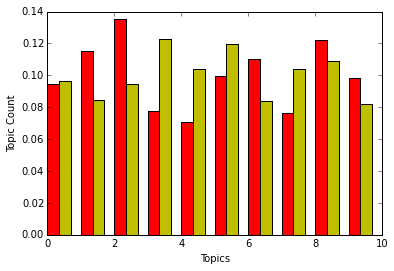

In [54]:
vc = clickbaitdf.Topic.value_counts(normalize=True)
nvc = nclickbaitdf.Topic.value_counts(normalize=True)

fig, ax = plt.subplots()

width = 0.35       # the width of the bars

clickbar = ax.bar(vc.index, vc, width, color='r')
nclickbar = ax.bar(nvc.index + width, nvc, width, color='y')

plt.xlabel('Topics')
plt.ylabel('Topic Count')
plt.show()

# Is there any relationship between time and labels?

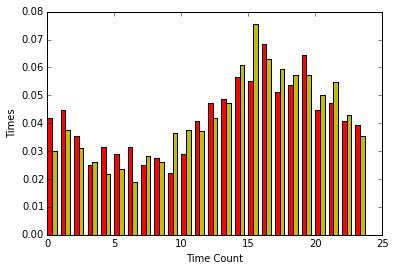

In [55]:
postTime = np.array(getTime(pandadata['postTimestamp']))

cpostTime = postTime[arr_index[0]]
ncpostTime = postTime[arr_nindex[0]]

uc,count_cpostTime = np.unique(cpostTime,return_counts=True)
unc,count_ncpostTime = np.unique(ncpostTime,return_counts=True)

count_cpostTime2 = count_cpostTime.astype(float) / len(cpostTime)
count_ncpostTime2 = count_ncpostTime.astype(float) / len(ncpostTime)

fig, ax2 = plt.subplots()

indexes = np.arange(0,24)
width = 0.35       # the width of the bars

clickbar = ax2.bar(uc, count_cpostTime2, width, color='r')
nclickbar = ax2.bar(unc+width, count_ncpostTime2, width, color='y')

plt.xlabel('Time Count')
plt.ylabel('Times')
plt.show()

# Analyzing the paragraphs

In [56]:
#Once the files are placed using pickle, use this to open them:
#sWords = cpickle.load(open('stopwords.p','rb')) #pickle does not stake string obejcts

pSPara = analyzePara(pandadata,pandaLdata,0)
print len(pSPara)
#Are there specific topics/themes (clustering) in the vocabulary of click-bait titles, use LDA to find out
#Create a vocabulary from the titles

dPara = corpora.Dictionary(pSPara)
cPara = [dPara.doc2bow(text) for text in pSPara] #the corpus 

#Since words are usually very sparse, the TfidfModel transformation will take into account how common a word is in
#a certain document compared to how common it is overall 
#so the algorithm won't just be looking at the most common, but uninformative words like the or and.
dmap = lambda dct, a: [dct[e] for e in a]

tPfidf = models.TfidfModel(cPara)
tPcorpus = dmap(tPfidf, cPara)



2343


In [57]:
print "Calculating Paragraph lda model for 5 topics"
Plda5 = gensim.models.ldamodel.LdaModel(corpus=tPcorpus, id2word=dPara, num_topics=5, update_every=1, chunksize=10000, passes=10)

print "\n Calculating Paragraph lda model for 10 topics"
Plda10 = gensim.models.ldamodel.LdaModel(corpus=tPcorpus, id2word=dPara, num_topics=10, update_every=1, chunksize=10000, passes=10)

#print "\n Calculating Paragraph lda model for 15 topics"
#Plda15 = gensim.models.ldamodel.LdaModel(corpus=tPcorpus, id2word=dPara, num_topics=15, update_every=1, chunksize=10000, passes=10)

#print "\n Calculating Paragraph lda model for 20 topics"
#Plda20 = gensim.models.ldamodel.LdaModel(corpus=tPcorpus, id2word=dPara, num_topics=25, update_every=1, chunksize=10000, passes=10)

print "Finished LDA model for Clickbait Paragraphs"

Calculating Paragraph lda model for 5 topics

 Calculating Paragraph lda model for 10 topics
Finished LDA model for Clickbait Paragraphs


In [8]:
#print pSPara[0]
#print





In [58]:
_kwargs = dict(formatted=0, num_words=20)

#**dict means "treat the key-value pairs in the dictionary as additional named arguments to this function call."
#topic words stores the word probablity for top 20 words in each topic. so it is a list of probablity of word in topic P(W|Z=z)
Ptopic_words = [[words for words in tups[1]] for tups in Plda10.show_topics(**_kwargs)]

#topicPdoc is an iterator that is transformed to contain the probablity of each topic in a document so, P(Z|D=d)
PtopicPdoc = Plda5[cPara]



Parray_ZD = np.zeros(shape = (len(cPara), 10))


for i,x in enumerate(PtopicPdoc):
    for j,y in enumerate(x):
        Parray_ZD[i,j] = y[1]





In [59]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
Ptsne_lda = tsne_model.fit_transform(Parray_ZD)


Pbest_topics = []
for i in range(0,len(Parray_ZD)):
    Pbest_topics += [Parray_ZD[i].argmax()]

print "Finished TSNE Model - Paragraphs"

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 2343
[t-SNE] Computed conditional probabilities for sample 2000 / 2343
[t-SNE] Computed conditional probabilities for sample 2343 / 2343
[t-SNE] Mean sigma: 0.000101
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.862808
[t-SNE] Error after 450 iterations: 0.862808
Finished TSNE Model - Paragraphs


In [65]:
print len(PtopicPdoc)

2343


In [60]:
Pplot_lda = bp.figure(plot_width=900, plot_height=700, title="Clickbait Paragraph - 10 topics (LDA)",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c", 
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5", 
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f", 
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5"
])

Pplot_lda.scatter(x=Ptsne_lda[:,0], y=Ptsne_lda[:,1], 
                 color=colormap[Pbest_topics][:len(PtopicPdoc)], 
                 source=bp.ColumnDataSource({
                    "title": ptitles[:len(PtopicPdoc)], 
                    "topic": Pbest_topics[:len(PtopicPdoc)]
                }))
hover = Pplot_lda.select(dict(type=HoverTool))
hover.tooltips=[("title","@title"),("topic","@topic")]
show(Pplot_lda)

c:\python27\lib\site-packages\bokeh\util\deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
c:\python27\lib\site-packages\bokeh\util\deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
c:\python27\lib\site-packages\bokeh\util\deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
c:\python27\lib\site-packages\bokeh\util\deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/iss

In [61]:
pyLDAvis.gensim.prepare(Plda5, tPcorpus, dPara)


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      60.797945        1       1 -0.055136 -0.013348
4      27.295913        1       2 -0.026111  0.021321
0       6.065371        1       3  0.019392 -0.005461
2       3.257536        1       4  0.028206 -0.002053
3       2.583235        1       5  0.033650 -0.000459, topic_info=      Category       Freq         Term      Total  loglift  logprob
term                                                               
35650  Default   4.000000       prison   4.000000  30.0000  30.0000
31650  Default   2.000000         matt   2.000000  29.0000  29.0000
40635  Default  12.000000       police  12.000000  28.0000  28.0000
46315  Default   5.000000         york   5.000000  27.0000  27.0000
1721   Default   4.000000     research   4.000000  26.0000  26.0000
3531   Default   3.000000    available   3.000000  25.0000  25.0000
16451  Default   1.000000     mitchell   1.000000  24.0000  24.0000
36957  Default   3.000000    currently   3.000000  23.0000  23.0000
36166  Default   3.000000         note   3.000000  22.0000  22.0000
46140  Default  12.000000        apple  12.000000  21.0000  21.0000
25426  Default   6.000000      clinton   6.000000  20.0000  20.0000
29619  Default   4.000000      warrior   4.000000  19.0000  19.0000
22777  Default   1.000000        sweat   1.000000  18.0000  18.0000
21467  Default   6.000000     buzzfeed   6.000000  17.0000  17.0000
21013  Default   1.000000       escape   1.000000  16.0000  16.0000
22907  Default   2.000000       inmate   2.000000  15.0000  15.0000
13815  Default   2.000000          lee   2.000000  14.0000  14.0000
19001  Default   3.000000       search   3.000000  13.0000  13.0000
26249  Default   6.000000          inc   6.000000  12.0000  12.0000
45379  Default   4.000000          nba   4.000000  11.0000  11.0000
25739  Default   6.000000         2017   6.000000  10.0000  10.0000
32725  Default   8.000000      officer   8.000000   9.0000   9.0000
12588  Default   3.000000     cavalier   3.000000   8.0000   8.0000
29448  Default   1.000000     featured   1.000000   7.0000   7.0000
31978  Default   2.000000        match   2.000000   6.0000   6.0000
31997  Default   4.000000    authority   4.000000   5.0000   5.0000
474    Default   3.000000       source   3.000000   4.0000   4.0000
23925  Default   1.000000     facility   1.000000   3.0000   3.0000
28275  Default  10.000000         game  10.000000   2.0000   2.0000
17324  Default   4.000000    cleveland   4.000000   1.0000   1.0000
...        ...        ...          ...        ...      ...      ...
22191   Topic5   0.053176      valeria   0.305377   1.9082  -9.2959
22478   Topic5   0.050956       piglet   0.294871   1.9006  -9.3385
11457   Topic5   0.063263  foofighters   0.368673   1.8935  -9.1222
25503   Topic5   0.050379   repubblica   0.299632   1.8732  -9.3499
4705    Topic5   0.048613  ballesteros   0.292625   1.8611  -9.3856
34718   Topic5   0.075950      waldorf   0.476407   1.8199  -8.9394
37094   Topic5   0.050618     thornton   0.321692   1.8068  -9.3452
34215   Topic5   0.045143       cheval   0.289888   1.7965  -9.4596
1607    Topic5   0.055309      bangkok   0.357609   1.7896  -9.2565
21717   Topic5   0.044074     mongoose   0.288580   1.7770  -9.4836
31740   Topic5   0.114399          min   0.751292   1.7740  -8.5298
39176   Topic5   0.073441      cycling   0.489278   1.7597  -8.9730
38471   Topic5   0.057936     relaxing   0.386303   1.7588  -9.2101
21210   Topic5   0.081436   substitute   0.547520   1.7505  -8.8697
22784   Topic5   0.042376         mota   0.287400   1.7418  -9.5229
26419   Topic5   0.041502         koda   0.282186   1.7393  -9.5437
37697   Topic5   0.041502        keelo   0.282186   1.7393  -9.5437
5668    Topic5   0.042514        vonny   0.289223   1.7388  -9.5196
5592    Topic5   0.058291        sofia   0.399834   1.7305  -9.2040
5774    Topic5   0.050142         swan   0.

# Lets see what happens when we separate clickbait and no-clickbait titles.    

In [62]:
#separate out clickbait and not-clickbait using  arr_index and arr_nindex 
arr_pStitles = np.array(pStitles)
cptitles = arr_pStitles[arr_index[0]]
ncptitles = arr_pStitles[arr_nindex[0]]

#create corpus and dicts for clickbait
Click_dTitles = corpora.Dictionary(cptitles)
Click_cTitles = [Click_dTitles.doc2bow(text) for text in cptitles] 

#create corpus and dicts for no-clickbait
NoClick_dTitles = corpora.Dictionary(ncptitles)
NoClick_cTitles = [NoClick_dTitles.doc2bow(text) for text in ncptitles] 

#Since words are usually very sparse, the TfidfModel transformation will take into account how common a word is in
#a certain document compared to how common it is overall 
#so the algorithm won't just be looking at the most common, but uninformative words like the or and.
dmap = lambda dct, a: [dct[e] for e in a]

#tfidf for clickbait
Click_tfidf = models.TfidfModel(Click_cTitles)
Click_tcorpus = dmap(Click_tfidf, Click_cTitles)

#tfidf for no-clickbait
NoClick_tfidf = models.TfidfModel(NoClick_cTitles)
NoClick_tcorpus = dmap(NoClick_tfidf, NoClick_cTitles)

print "Calculating lda model for 5 topics for clickbait"
clda5 = gensim.models.ldamodel.LdaModel(corpus=Click_tcorpus, id2word=Click_dTitles, num_topics=5, update_every=1, chunksize=10000, passes=10)

print "Calculating lda model for 5 topics for not-clickbait"
nclda5 = gensim.models.ldamodel.LdaModel(corpus=NoClick_tcorpus, id2word=NoClick_dTitles, num_topics=5, update_every=1, chunksize=10000, passes=10)

print "finish calculating topics"



Calculating lda model for 5 topics for clickbait
Calculating lda model for 5 topics for not-clickbait
finish calculating topics


In [63]:
pyLDAvis.gensim.prepare(clda5, Click_tcorpus, Click_dTitles)
#print clda5.show_topics(-1)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      27.403624        1       1 -0.086184  0.013130
0      18.873412        1       2  0.020135 -0.003341
1      18.536133        1       3  0.031797  0.035315
3      17.764448        1       4  0.026442  0.022980
2      17.422384        1       5  0.007809 -0.068085, topic_info=     Category      Freq        Term     Total  loglift  logprob
term                                                           
1077  Default  4.000000    business  4.000000  30.0000  30.0000
661   Default  3.000000     insider  3.000000  29.0000  29.0000
1911  Default  2.000000        vine  2.000000  28.0000  28.0000
682   Default  3.000000       trump  3.000000  27.0000  27.0000
1204  Default  2.000000         abc  2.000000  26.0000  26.0000
348   Default  4.000000        news  4.000000  25.0000  25.0000
1554  Default  1.000000           9  1.000000  24.0000  24.0000
926   Default  1.000000       sport  1.000000  23.0000  23.0000
1338  Default  1.000000     brother  1.000000  22.0000  22.0000
935   Default  1.000000     reading  1.000000  21.0000  21.0000
1769  Default  3.000000       apple  3.000000  20.0000  20.0000
23    Default  2.000000       every  2.000000  19.0000  19.0000
1914  Default  2.000000         see  2.000000  18.0000  18.0000
666   Default  2.000000       today  2.000000  17.0000  17.0000
1032  Default  1.000000       money  1.000000  16.0000  16.0000
1086  Default  1.000000        fell  1.000000  15.0000  15.0000
1318  Default  2.000000         ceo  2.000000  14.0000  14.0000
1310  Default  1.000000    actually  1.000000  13.0000  13.0000
1006  Default  1.000000        food  1.000000  12.0000  12.0000
868   Default  3.000000    jurassic  3.000000  11.0000  11.0000
412   Default  1.000000     dolezal  1.000000  10.0000  10.0000
769   Default  1.000000       space  1.000000   9.0000   9.0000
1484  Default  1.000000      europe  1.000000   8.0000   8.0000
2033  Default  1.000000      jenner  1.000000   7.0000   7.0000
1226  Default  1.000000      brutal  1.000000   6.0000   6.0000
1072  Default  1.000000     hipster  1.000000   5.0000   5.0000
951   Default  1.000000    personal  1.000000   4.0000   4.0000
78    Default  1.000000       music  1.000000   3.0000   3.0000
1922  Default  3.000000        need  3.000000   2.0000   2.0000
375   Default  1.000000        much  1.000000   1.0000   1.0000
...       ...       ...         ...       ...      ...      ...
1347   Topic5  0.510225  psychology  0.900338   1.1795  -6.5510
1269   Topic5  0.510218     awkward  0.900339   1.1795  -6.5510
1037   Topic5  0.702550       speed  1.263417   1.1606  -6.2311
1310   Topic5  1.025838    actually  1.933940   1.1134  -5.8526
832    Topic5  0.766063          13  1.437378   1.1181  -6.1446
1662   Topic5  0.852273      planet  1.628687   1.0998  -6.0379
951    Topic5  0.809449    personal  1.545252   1.1008  -6.0895
1939   Topic5  0.774527      debate  1.483371   1.0976  -6.1336
836    Topic5  0.704169          17  1.416715   1.0483  -6.2288
1599   Topic5  0.847839      google  1.892803   0.9443  -6.0431
348    Topic5  1.356844        news  4.375981   0.5764  -5.5729
490    Topic5  0.751136         cnn  1.663559   0.9523  -6.1642
1736   Topic5  0.669376        slow  1.380110   1.0238  -6.2795
945    Topic5  0.736147        come  1.645893   0.9428  -6.1844
281    Topic5  0.624387        tech  1.242191   1.0596  -6.3491
1781   Topic5  0.797985        next  2.016110   0.8206  -6.1037
381    Topic5  0.979677        life  3.247615   0.5490  -5.8986
850    Topic5  0.972528         say  3.251686   0.5404  -5.9059
969    Topic5  0.755251      better  1.987724   0.7797  -6.1588
631    Topic5  0.672767      muslim  1.523935   0.9298  -6.2744
574    Topic5  0.871694        time  3.140451   0.4657  -6.0154
2057   Topic5  0.719583      latest  1.871209   0.7917  -6.2072
1797   Topic5  0.687117     escaped  1.800752   0.7840  -6.

In [64]:
pyLDAvis.gensim.prepare(nclda5, NoClick_tcorpus, NoClick_dTitles)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      34.915513        1       1  0.150682 -0.000421
3      20.035711        1       2 -0.043377 -0.004925
1      15.668121        1       3 -0.037397 -0.054706
0      15.114437        1       4 -0.035829  0.085410
4      14.266217        1       5 -0.034079 -0.025358, topic_info=     Category       Freq       Term      Total  loglift  logprob
term                                                            
938   Default  14.000000      trump  14.000000  30.0000  30.0000
1477  Default   6.000000   business   6.000000  29.0000  29.0000
1660  Default  10.000000        abc  10.000000  28.0000  28.0000
855   Default   4.000000  watchespn   4.000000  27.0000  27.0000
2230  Default   4.000000  streaming   4.000000  26.0000  26.0000
910   Default   5.000000    insider   5.000000  25.0000  25.0000
1433  Default   8.000000      world   8.000000  24.0000  24.0000
2282  Default   5.000000     lebron   5.000000  23.0000  23.0000
1036  Default   6.000000      james   6.000000  22.0000  22.0000
831   Default   7.000000   democrat   7.000000  21.0000  21.0000
2691  Default   3.000000     dallas   3.000000  20.0000  20.0000
2975  Default   6.000000    twitter   6.000000  19.0000  19.0000
2042  Default   3.000000       vine   3.000000  18.0000  18.0000
1010  Default   8.000000     police   8.000000  17.0000  17.0000
1168  Default   6.000000     online   6.000000  16.0000  16.0000
270   Default   7.000000        gop   7.000000  15.0000  15.0000
2565  Default   6.000000       2015   6.000000  14.0000  14.0000
1658  Default   7.000000        nba   7.000000  13.0000  13.0000
106   Default   2.000000   hospital   2.000000  12.0000  12.0000
1837  Default   4.000000    england   4.000000  11.0000  11.0000
633   Default   6.000000   attorney   6.000000  10.0000  10.0000
1419  Default   3.000000       blog   3.000000   9.0000   9.0000
2198  Default   4.000000        cup   4.000000   8.0000   8.0000
1114  Default   4.000000          2   4.000000   7.0000   7.0000
1252  Default   4.000000       espn   4.000000   6.0000   6.0000
867   Default   4.000000          v   4.000000   5.0000   5.0000
2608  Default   5.000000  dismissal   5.000000   4.0000   4.0000
2455  Default   6.000000      apple   6.000000   3.0000   3.0000
240   Default   3.000000   arrested   3.000000   2.0000   2.0000
123   Default   7.000000      yahoo   7.000000   1.0000   1.0000
...       ...        ...        ...        ...      ...      ...
2718   Topic5   0.804695    waldorf   1.303317   1.4651  -6.8221
1262   Topic5   0.789455  mcdonalds   1.284774   1.4603  -6.8412
3043   Topic5   0.777086    biggest   1.272389   1.4542  -6.8570
1494   Topic5   0.804369   favorite   1.317277   1.4540  -6.8225
2156   Topic5   0.776704      grant   1.278595   1.4488  -6.8575
2282   Topic5   3.359623     lebron   5.731816   1.4131  -5.3929
2100   Topic5   1.417156     secret   2.393931   1.4230  -6.2561
2473   Topic5   1.154473     camera   1.946685   1.4248  -6.4611
1036   Topic5   3.144938      james   6.031877   1.2960  -5.4590
1433   Topic5   4.378134      world   8.984378   1.2284  -5.1281
2231   Topic5   1.275244   economic   2.310391   1.3530  -6.3616
2198   Topic5   2.348502        cup   4.999188   1.1918  -5.7510
2056   Topic5   1.262407      movie   2.325786   1.3362  -6.3717
607    Topic5   1.545339       save   3.232747   1.2092  -6.1695
1114   Topic5   1.881099          2   4.756661   1.0196  -5.9729
550    Topic5   1.775080       make   4.808679   0.9507  -6.0309
713    Topic5   1.542068       head   3.718205   1.0672  -6.1716
2961   Topic5   1.785787       like   5.723854   0.7825  -6.0249
2214   Topic5   2.007837       game   7.850085   0.5838  -5.9077
468    Topic5   2.217065       news  14.171542   0.0922  -5.8086
1880   Topic5   1.391214   american   3.789798   0.9451  -6.2746
308    Topic5   1.214514    service   2.611235   1.1818  -6.4104
1752

# Can't really tell if there are any common themes in the topics.

Moving onto individual token analysis.  Probably inefficient way of doing this, 
was too lazy to go back and make edit to functions.

In [11]:
print ptitles[0]

[u'Apple', u'gives', u'back', u'gigabytes', u':', u'iOS', u'9', u"'", u'app', u'thinning', u"'", u'feature', u'will', u'finally', u'give', u'your', u"phone's", u'storage', u'a', u'boost']


In [27]:
#sWords, eWords, cWords, nNums, aTokens

csWords = []
ceWords = []
ccWords = []
cnNums = []
ncsWords= []
nceWords= []
nccWords= []
ncnNums= []
cToken=[]
ncToken=[]

#See the different frequency distributions between clickbait and not-clickbait titles
for i,titles in enumerate(ptitles):
    for token in titles:
        if pandaLdata['truthClass'][i] == 'clickbait':
            if token in sWords:
                csWords.append(token)
            if token in eWords:
                ceWords.append(token)
            if token in cWords:
                ccWords.append(token)
            if token in nNums:
                if float(token) < 2000.0:
                    cnNums.append(token)
            cToken.append(token)
        else:
            if token in sWords:
                ncsWords.append(token)
            if token in eWords:
                nceWords.append(token)
            if token in cWords:
                nccWords.append(token)
            if token in nNums:
                if float(token) < 2000.0:
                    ncnNums.append(token)
            ncToken.append(token)
        




In [29]:
#print ncnNums

In [39]:
clenStop = len(csWords)/(len(csWords)+len(ncsWords)*1.0)
clenEng = len(ceWords)/(len(ceWords)+len(ncsWords)*1.0)
clencWords = len(ccWords)/(len(ccWords)+len(nccWords)*1.0)
clenNums = len(cnNums)/(len(cnNums)+len(ncnNums)*1.0)

nclenStop = len(ncsWords)/(len(ncToken)*1.0)
nclenEng = len(nceWords)/(len(ncToken)*1.0)
nclencWords = len(nccWords)/(len(ncToken)*1.0)
nclenNums = len(ncnNums)/(len(cnNums)+len(ncnNums)*1.0)


cDistWords = [clenStop,clenEng,clencWords,clenNums]
ncDistWords = [nclenStop,nclenEng,nclencWords,nclenNums]



In [40]:
print len(cnNums), len(ncnNums)
print ncDistWords
print cDistWords



207 492
[0.1794142129817837, 0.07863406701899064, 0.02729542946744875, 0.703862660944206]
[0.2475440448161078, 0.12051622698804328, 0.21710161021654636, 0.296137339055794]


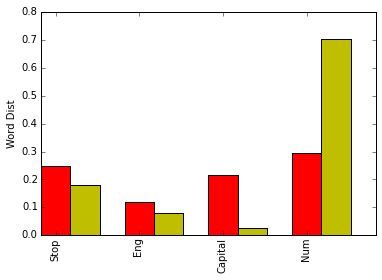

In [41]:
%matplotlib inline
fig, ax = plt.subplots()

N = np.arange(4)
width = 0.35       # the width of the bars

clickbar = ax.bar(N, cDistWords, width, color='r')
nclickbar = ax.bar(N + width, ncDistWords , width, color='y')

for tick in ax.get_xticklabels():
    tick.set_rotation(90)
    
ax.set_xticks(N + width / 2)
ax.set_xticklabels(('Stop', 'Eng', 'Capital', 'Num'))


plt.ylabel('Word Dist')
plt.show()


There are a lot more CAPITAL words in clickbait titles, and seems like a lot more numbers in non-clickbait titles, so titles that probably are lists should use bi-gram type models, or parts-of-speech tag, so NUM + PoS.
